In [18]:
import pathlib
from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torchvision
import requests
import tarfile
import shutil
import torch
import os

In [2]:
URL = "https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz"
FILENAME = "images.tar.gz"
DATASET_FOLDER = "dataset"
CLASSES = ["newfoundland", "saint bernard", "samoyed"]
_ = torch.manual_seed(42)

### Step 1 - Create a custom dataset featuring 3 custom categories of atleast 100 images each

In [3]:
# Modified the code from demo code/Image_Classification_CNN.ipynb to also show progress bar
def download_and_extract_tar(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024  # 1 KB

    try:
        from tqdm import tqdm
        with open(filename, "wb") as file, tqdm(
            desc=filename,
            total=total_size,
            unit="iB",
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
            for data in response.iter_content(block_size):
                size = file.write(data)
                progress_bar.update(size)
    except:
        import urllib.request
        urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()

    os.remove(filename)

In [6]:
if not os.path.exists("images") or not os.path.exists("dataset"):
    download_and_extract_tar(URL, FILENAME)
else:
    print("dataset is already downloaded and extracted")

dataset is already downloaded and extracted


In [13]:
# Filter the images from the downloaded dataset to only include the classes specified above
# Save those filtered images in a new folder using the ImageDataset folder structure
# dataset
#   |- newfoundland
#   |   |- newfoundland_1.jpg
#   |   |- newfoundland_2.jpg
#   |- saint bernard
#   |   | - saint_bernard_1.jpg
#   |   | - saint_bernard_2.jpg
#   |- samoyed
#   |   | - samoyed_1.jpg
#   |   | - samoyed_2.jpg

def filter_images(raw_data_folder, dataset_folder, include_classes):
    classes = set()
    image_count = 0
    if not os.path.exists(dataset_folder):
        os.mkdir(dataset_folder)
    for filename in os.listdir(raw_data_folder):
        if filename.startswith("."):
            # ignore hidden files
            continue
        if filename[0].isupper():
            # ignore cat images
            continue
        classname = " ".join(filename.split("_")[:-1])
        if classname not in include_classes:
            continue
        image_count += 1
        classes.add(classname)
        folder = os.path.join(dataset_folder, classname)
        if not os.path.exists(folder):
            os.mkdir(folder)
        if os.path.exists(os.path.join(folder, filename)):
            continue
        shutil.copyfile(
            os.path.join(raw_data_folder, filename), os.path.join(folder, filename)
        )
    print(f"extracted {image_count} images belonging to {len(classes)} classes")

if not os.path.exists("dataset"): # if dataset folder already present, the data will not be filtered or extracted again.
    filter_images("images", DATASET_FOLDER, CLASSES)

extracted 600 images belonging to 3 classes


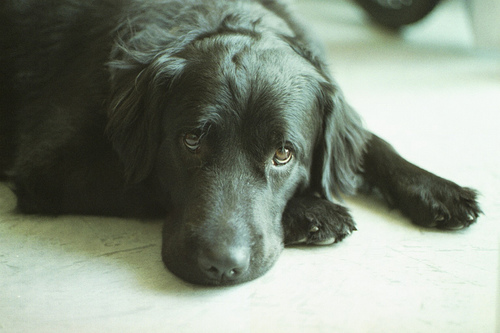

In [16]:
# Showing sample images from the dataset
newfoundland_path = pathlib.Path(DATASET_FOLDER) / "newfoundland"  # Ensure correct path using pathlib
newfoundland_imgs = list(newfoundland_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(newfoundland_imgs[0]))

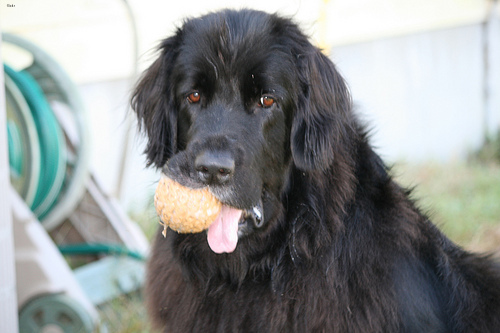

In [17]:
Image.open(str(newfoundland_imgs[91]))

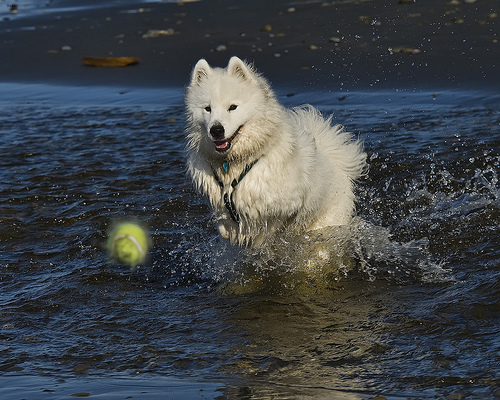

In [19]:
# Showing sample images from the dataset
samoyed_path = pathlib.Path(DATASET_FOLDER) / "samoyed"  # Ensure correct path using pathlib
samoyed_imgs = list(samoyed_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(samoyed_imgs[0]))

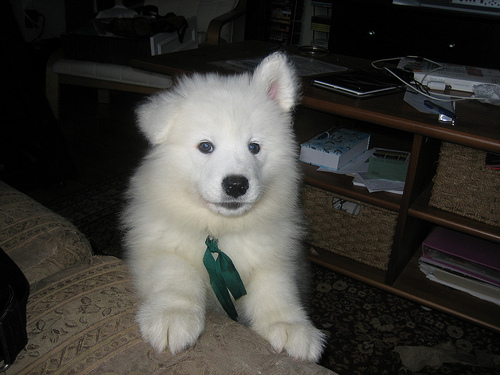

In [21]:
Image.open(str(samoyed_imgs[37]))

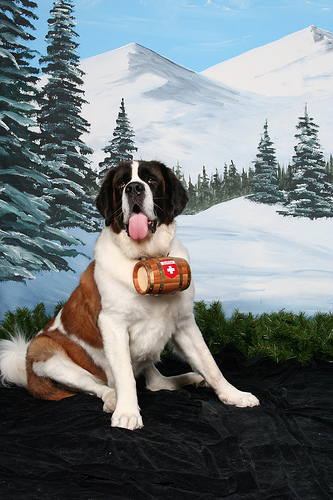

In [22]:
# Showing sample images from the dataset
saintbernard_path = pathlib.Path(DATASET_FOLDER) / "saint bernard"  # Ensure correct path using pathlib
saintbernard_imgs = list(saintbernard_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(saintbernard_imgs[0]))

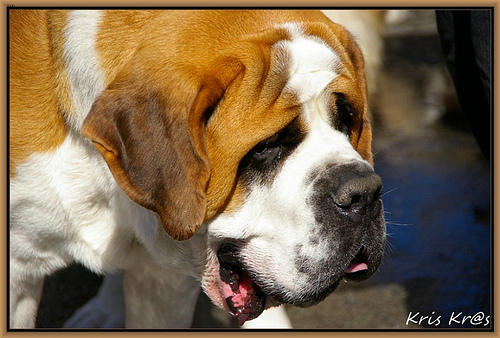

In [31]:
Image.open(str(saintbernard_imgs[42]))

### Step 2 and 3 - Split this data between 80% training and 20% test and Preprocess the data as you see fit

In [8]:
# Specifying the transformations needed for train and test split
# Training data transformation require more transformation compared to test data
# this includes - 
#   - resize the image to 256 pixels on the short edge
#   - randomly rotate image by 10 degrees
#   - take a random crop of size 224 x 224
#   - randomly flip the image horizontally
#   - randomly change the contrast of the image
#   - convert the image to a tensor (it also normalizes the image to [0, 1])
train_data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.RandomCrop(224),
        torchvision.transforms.RandomHorizontalFlip(0.5),
        torchvision.transforms.RandomAutocontrast(0.5),
        torchvision.transforms.ToTensor(),
    ]
)

# test data transformations are more simple
# this includes - 
#   - resize the image to 256 pixels on the short edge
#   - take a center crop of size 224 x 224
#   - convert the image to a tensor (it also normalizes the image to [0, 1])
test_data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
    ]
)

In [9]:
# Step 2 - Split the dataset 80-20 between train and test
# This is different from the demo since different transformations are used here for train and test dataset. 

# create train and test datasets with the full data, but different transformations
train_dataset = torchvision.datasets.ImageFolder(
    DATASET_FOLDER, transform=train_data_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    DATASET_FOLDER, transform=test_data_transforms
)

# split the data indices into train and test in 80-20 ratio
train_indices, test_indices = train_test_split(
    [i for i in range(len(train_dataset))],
    train_size=0.8,
    random_state=42,
    shuffle=True,
)

# create subsets of the full dataset using the train and test indices
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

In [10]:
print(f"Size of train data - {len(train_dataset)}")
print(f"Size of test data - {len(test_dataset)}")
print(f"Classes in dataset - {", ".join(train_dataset.dataset.classes)}")

Size of train data - 480
Size of test data - 120
Classes in dataset - newfoundland, saint bernard, samoyed


In [34]:
print(f"Shape of image from train split - {train_dataset[0][0].shape}")
print(f"Shape of image from test split - {test_dataset[0][0].shape}")

Shape of image from train split - torch.Size([3, 224, 224])
Shape of image from train split - torch.Size([3, 224, 224])


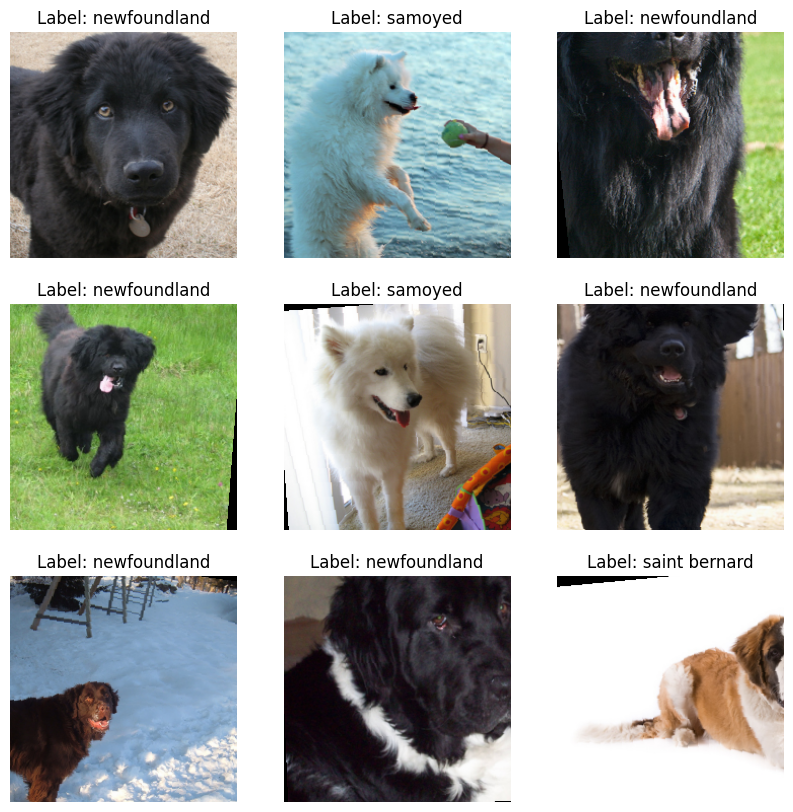

In [35]:
# Ploting 9 samples from the training dataset
plt.figure(figsize=(10, 10))
for i in range(9):
    # change the image shape - before -> [3, 224, 224] after -> [224, 224, 3]
    image = train_dataset[i+10][0].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {train_dataset.dataset.classes[train_dataset[i+10][1]]}")
    plt.axis("off")
plt.show()

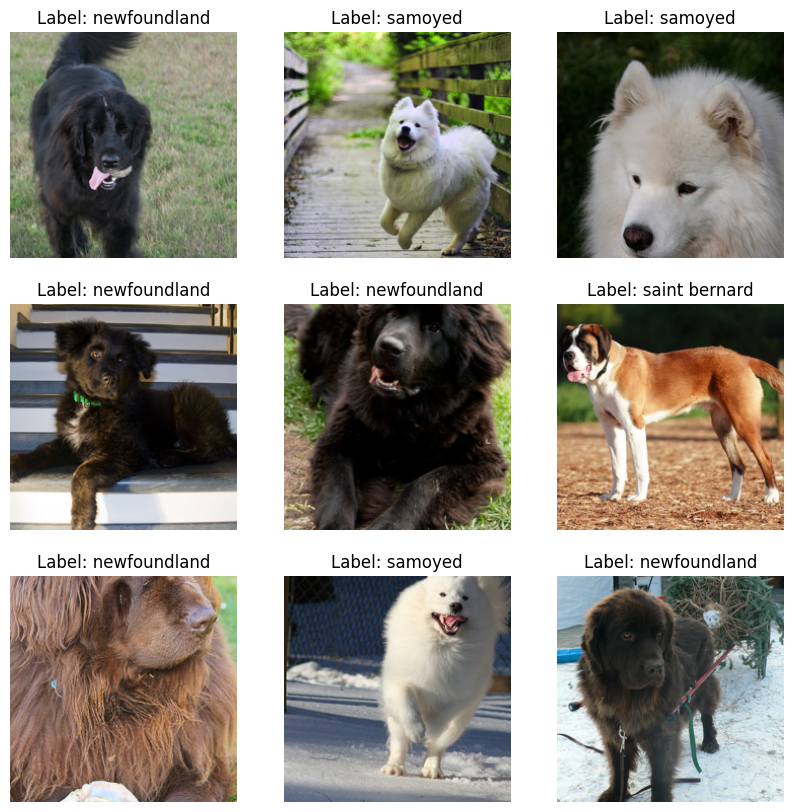

In [36]:
# Ploting 9 samples from the test dataset
plt.figure(figsize=(10, 10))
for i in range(9):
    image = test_dataset[i][0].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {test_dataset.dataset.classes[test_dataset[i][1]]}")
    plt.axis("off")

plt.show()

### Step 4 - Create a Convolutional Neural Network model to learn about your training set

In [37]:
# Similar model to the one shown in demo, but with 1 more convolutional layer
class CustomCNN(torch.nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CustomCNN, self).__init__()
        
        # same layer as demo, it just rescales the input using
        # convolutional kernel of size 1 and 3 channels, and then applying batchnorm
        # to rescale the input
        self.rescaling = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1),
            torch.nn.BatchNorm2d(num_features=3),
            torch.nn.ReLU(inplace=True),
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, padding=1
        )
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, padding=1
        )
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1
        )
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # this layer collapses all the dimensions beyond 0 to a single dimension
        # example - [10, 3, 244, 244] -> [10, 3 * 244 * 244]
        self.flatten = torch.nn.Flatten()
        
        # since we used 4 maxpooling layers of kernel size 2 and stride 2,
        # we effectively divided the image height and width by 2^4=16
        self.fc1 = torch.nn.Linear(
            in_features=128 * (img_height // 16) * (img_width // 16), out_features=128
        )
        self.fc2 = torch.nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # example - x is of shape [10, 3, 224, 224]
        x = self.rescaling(x)  # shape - [10, 3, 224, 224]
        x = self.conv1(x)  # shape - [10, 16, 224, 224]
        x = torch.nn.functional.relu(x)  # shape - [10, 16, 224, 224]
        x = self.pool1(x)  # shape - [10, 16, 112, 112]
        x = self.conv2(x)  # shape - [10, 32, 112, 112]
        x = torch.nn.functional.relu(x)  # shape - [10, 32, 112, 112]
        x = self.pool2(x)  # shape - [10, 32, 56, 56]
        x = self.conv3(x)  # shape - [10, 64, 56, 56]
        x = torch.nn.functional.relu(x)  # shape - [10, 64, 56, 56]
        x = self.pool3(x)  # shape - [10, 64, 28, 28]
        x = self.conv4(x)  # shape - [10, 128, 28, 28]
        x = torch.nn.functional.relu(x)  # shape - [10, 128, 28, 28]
        x = self.pool4(x)  # shape - [10, 128, 14, 14]
        x = self.flatten(x)  # shape - [10, 25088]
        x = self.fc1(x)  # shape - [10, 128]
        x = torch.nn.functional.relu(x)  # shape - [10, 128]
        x = self.fc2(x)  # shape - [10, 3]
        return x

In [38]:
# Creating the model object
model = CustomCNN(len(CLASSES), 224, 224)
print(model)

CustomCNN(
  (rescaling): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (fc2): Linear(in_feat

In [39]:
OPTIMIZER = torch.optim.Adam(params=model.parameters())
CRITERION = torch.nn.CrossEntropyLoss()
BATCH_SIZE = 32
NUM_EPOCHS = 1000
PATIENCE = 10

In [40]:
# This function calculates the accuracy using argmax
# example:
# If the input data was of shape [2, 3, 224, 224], the model output will be something of shape [2, 3]
# like,
# [
#   [9.1, -1.2, 3.4],
#   [2.1, 0.1, 5.6],
# ]
# torch max will convert this to the following in the preds variable
# [
#   [0],
#   [2]
# ]
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [41]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [46]:
# Printing the shape and labels of a batch from train_loader
for idx, data in enumerate(train_dataloader):
    datas = data[0]
    labels = data[1]
    print("Datas shape:", datas.shape)
    print("Labels:", labels)
    break

Datas shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        2, 0, 1, 2, 0, 0, 2, 2])


In [47]:
# Printing the shape and labels of a batch from test_loader
for idx, data in enumerate(test_dataloader):
    datas = data[0]
    labels = data[1]
    print("Datas shape:", datas.shape)
    print("Labels:", labels)
    break

Datas shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2,
        1, 2, 0, 0, 2, 2, 2, 0])


In [48]:
# Training the model using train data loader and keeping track of training metrics like accuracy and loss
def train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience
):
    counter = 0
    history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
    best_val_loss = float("inf")
    best_model_state = None
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        # iterate over the batches from training data
        for images, labels in train_dataloader:
            # reset the gradients for optimizer
            optimizer.zero_grad()
            # make predictions using the current model weights
            outputs = model(images)
            # calculate loss based on the current prediction
            loss = criterion(outputs, labels)
            # compute the gradients for each weight in the model
            loss.backward()
            # propagate the gradients to each layers and update each weight
            optimizer.step()
            # accumulate the loss from this training batch
            train_loss += loss.item() * images.size(0)
            # accumulate the correct predictions from this batch
            train_accuracy += accuracy(outputs, labels).item() * images.size(0)
        # training statistics
        train_loss /= len(train_dataloader.dataset)
        train_accuracy /= len(train_dataloader.dataset)

        # set the model to evaluation mode
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        # disable gradient propagation
        with torch.no_grad():
            # iterate over the batches from test data
            for images, labels in val_dataloader:
                # make predictions using the current model weights
                outputs = model(images)
                # calculate loss based on the current prediction
                loss = criterion(outputs, labels)
                # accumulate the loss from this batch
                val_loss += loss.item() * images.size(0)
                # accumulate the correct predictions from this batch
                val_accuracy += accuracy(outputs, labels).item() * images.size(0)
        # validation statistics
        val_loss /= len(val_dataloader.dataset)
        val_accuracy /= len(val_dataloader.dataset)

        # log the history of this training epoch
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        # print statistics
        print(
            f"Epoch [{epoch+1}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f}",
            f"Train Accuracy: {train_accuracy:.4f}",
            f"Validation Loss: {val_loss:.4f}",
            f"Validation Accuracy: {val_accuracy:.4f}",
        )

        # early stopping criteria
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    return history

In [49]:
history = train_model(
    model, train_dataloader, test_dataloader, CRITERION, OPTIMIZER, NUM_EPOCHS, PATIENCE
)

Epoch [1/1000] Train Loss: 1.0418 Train Accuracy: 0.4188 Validation Loss: 1.2967 Validation Accuracy: 0.3417
Epoch [2/1000] Train Loss: 0.7653 Train Accuracy: 0.6750 Validation Loss: 0.6038 Validation Accuracy: 0.7583
Epoch [3/1000] Train Loss: 0.5809 Train Accuracy: 0.7354 Validation Loss: 0.4905 Validation Accuracy: 0.8000
Epoch [4/1000] Train Loss: 0.5719 Train Accuracy: 0.7688 Validation Loss: 0.4787 Validation Accuracy: 0.7833
Epoch [5/1000] Train Loss: 0.4914 Train Accuracy: 0.7979 Validation Loss: 0.4607 Validation Accuracy: 0.8083
Epoch [6/1000] Train Loss: 0.4513 Train Accuracy: 0.8125 Validation Loss: 0.4706 Validation Accuracy: 0.8000
Epoch [7/1000] Train Loss: 0.4819 Train Accuracy: 0.8167 Validation Loss: 0.4115 Validation Accuracy: 0.8417
Epoch [8/1000] Train Loss: 0.4399 Train Accuracy: 0.8250 Validation Loss: 0.4774 Validation Accuracy: 0.7667
Epoch [9/1000] Train Loss: 0.4301 Train Accuracy: 0.8354 Validation Loss: 0.4090 Validation Accuracy: 0.8250
Epoch [10/1000] Tra

In [50]:
metrics = pd.DataFrame(history)
metrics = metrics.reset_index(names="epoch")
metrics["epoch"] = metrics["epoch"] + 1
metrics.head()

epoch  train_loss  train_accuracy  val_loss  val_accuracy
0      1    1.041778        0.418750  1.296657      0.341667
1      2    0.765281        0.675000  0.603800      0.758333
2      3    0.580867        0.735417  0.490488      0.800000
3      4    0.571918        0.768750  0.478661      0.783333
4      5    0.491382        0.797917  0.460749      0.808333

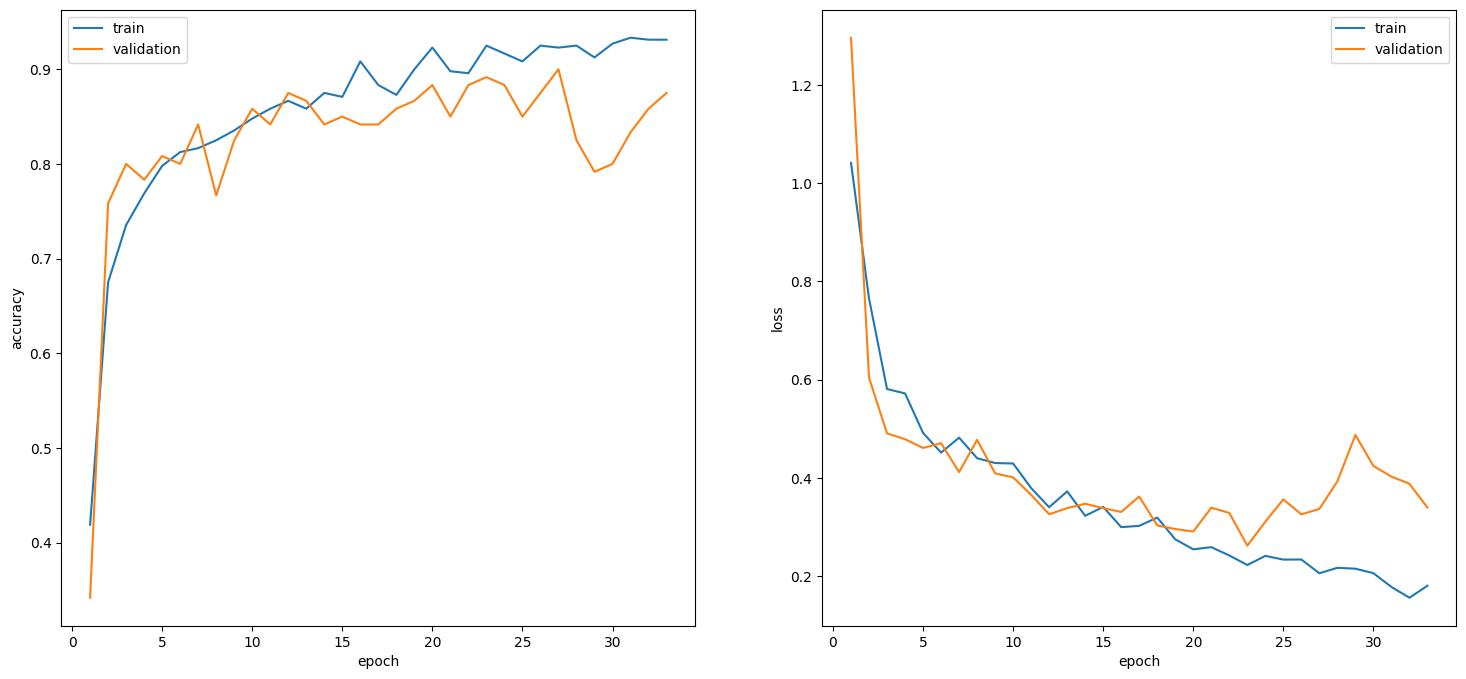

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
_ = sns.lineplot(metrics, x="epoch", y="train_accuracy", c="tab:blue", legend="brief", label="train", ax=ax[0])
_ = sns.lineplot(metrics, x="epoch", y="val_accuracy", c="tab:orange", legend="brief", label="validation", ax=ax[0])
_ = ax[0].set_ylabel("accuracy")
_ = sns.lineplot(metrics, x="epoch", y="train_loss", c="tab:blue", legend="brief", label="train", ax=ax[1])
_ = sns.lineplot(metrics, x="epoch", y="val_loss", c="tab:orange", legend="brief", label="validation", ax=ax[1])
_ = ax[1].set_ylabel("loss")

### Step 5 - Make predictions on the test data and compare them to the expected categories

In [52]:
y_test = []
y_pred = []
for images, labels in test_dataloader:
    outputs = model(images)
    y_pred.extend(torch.max(outputs, dim=1)[1].tolist())
    y_test.extend(labels.tolist())

results = pd.DataFrame(
    {
        "y_true": y_test,
        "y_pred": y_pred,
    }
)
print(f"Test Accuracy - {accuracy_score(results["y_true"], results["y_pred"]):.6f}")

Test Accuracy - 0.891667


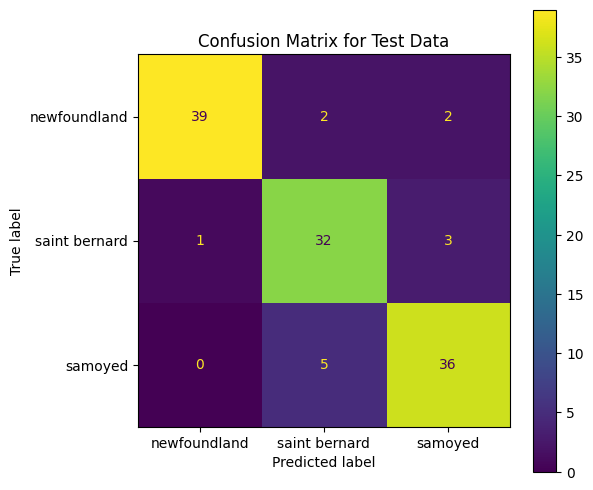

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(results["y_true"], results["y_pred"])
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
_ = disp.plot(ax=ax)
_ = ax.set_title("Confusion Matrix for Test Data")

We can see from the above confusion matrix that the Custom CNN model performed well on this classification task. 
- It misclassified 4 Newfoundland dogs as Saint bernard or Samoyed.
- It misclassified 4 Saint Bernard dogs as Newfoundland or Samoyed.
- It misclassified 5 Samoyed dogs as Saint Bernard.

Overall it achieved 89.16% accuracy on the test dataset.

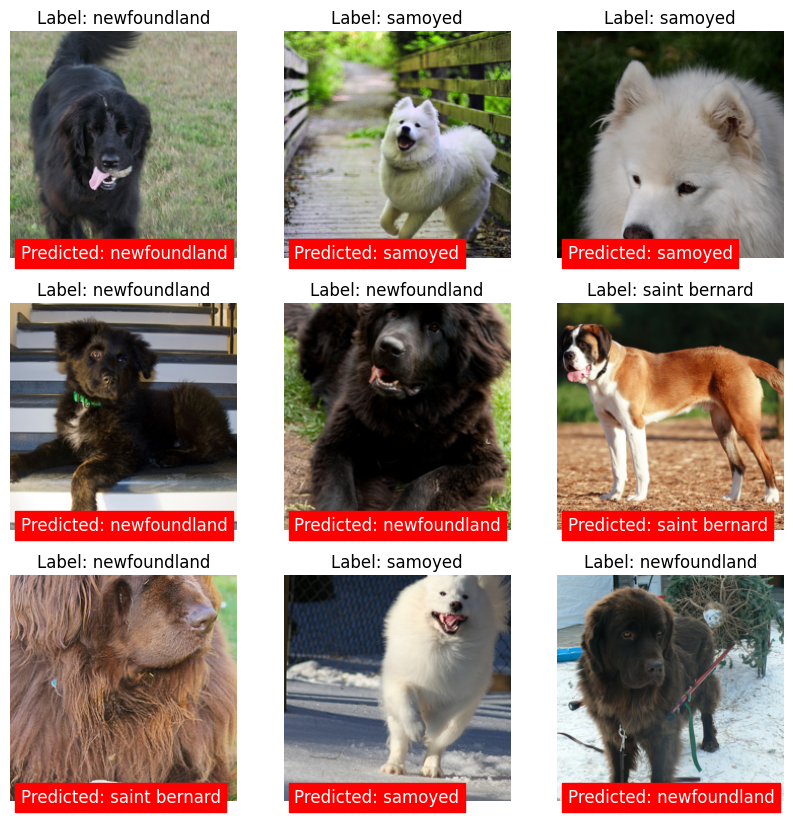

In [54]:
plt.figure(figsize=(10, 10))
for i in range(9):
    image = test_dataset[i][0].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {test_dataset.dataset.classes[test_dataset[i][1]]}")
    plt.text(
        10,
        224,
        f"Predicted: {CLASSES[y_pred[i]]}",
        fontsize=12,
        color="white",
        backgroundcolor="red",
    )
    plt.axis("off")

plt.show()

### Step 6 - Use GoogLeNet (InceptionNet) and add a Linear layer on top of it

In [55]:
# Download the GoogLeNet model
googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
# freeze the weights
for _, param in googlenet.named_parameters():
    param.requires_grad = False

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/nbthakur/.cache/torch/hub/v0.10.0.zip
/Users/nbthakur/Code/Deep Learning/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nbthakur/Code/Deep Learning/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/nbthakur/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 30.4MB/s]


In [56]:
class CustomGoogLeNet(torch.nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomGoogLeNet, self).__init__()
        self.pretrained = pretrained_model
        self.fc1 = torch.nn.Linear(in_features=1000, out_features=num_classes)

    def forward(self, x):
        # example - shape of x is [10, 3, 224, 224]
        x = self.pretrained(x)  # shape -[10, 1000]
        x = self.fc1(x)  # shape - [10, 3]
        return x

In [57]:
# Creating model object
model = CustomGoogLeNet(googlenet, len(CLASSES))
print(model)

CustomGoogLeNet(
  (pretrained): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

### Step 7 - Train the GoogLeNet model and compare the accuracy with the first model

In [58]:
OPTIMIZER = torch.optim.Adam(params=model.parameters())
CRITERION = torch.nn.CrossEntropyLoss()
BATCH_SIZE = 32
NUM_EPOCHS = 1000
PATIENCE = 10

In [59]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [60]:
# Same as previous training data transforms there is also a new transformation that standardizes the data
# using the mean and standard deviation of the GoogLeNet model
train_data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.RandomCrop(224),
        torchvision.transforms.RandomHorizontalFlip(0.5),
        torchvision.transforms.RandomAutocontrast(0.5),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
test_data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
train_dataset = torchvision.datasets.ImageFolder(
    DATASET_FOLDER, transform=train_data_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    DATASET_FOLDER, transform=test_data_transforms
)
train_indices, test_indices = train_test_split(
    [i for i in range(len(train_dataset))],
    train_size=0.8,
    random_state=42,
    shuffle=True,
)
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [61]:
def train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience
):
    counter = 0
    history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
    best_val_loss = float("inf")
    best_model_state = None
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        # iterate over the batches from training data
        for images, labels in train_dataloader:
            # reset the gradients for optimizer
            optimizer.zero_grad()
            # make predictions using the current model weights
            outputs = model(images)
            # calculate loss based on the current prediction
            loss = criterion(outputs, labels)
            # compute the gradients for each weight in the model
            loss.backward()
            # propagate the gradients to each layers and update each weight
            optimizer.step()
            # accumulate the loss from this training batch
            train_loss += loss.item() * images.size(0)
            # accumulate the correct predictions from this batch
            train_accuracy += accuracy(outputs, labels).item() * images.size(0)
        # training statistics
        train_loss /= len(train_dataloader.dataset)
        train_accuracy /= len(train_dataloader.dataset)

        # set the model to evaluation mode
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        # disable gradient propagation
        with torch.no_grad():
            # iterate over the batches from test data
            for images, labels in val_dataloader:
                # make predictions using the current model weights
                outputs = model(images)
                # calculate loss based on the current prediction
                loss = criterion(outputs, labels)
                # accumulate the loss from this batch
                val_loss += loss.item() * images.size(0)
                # accumulate the correct predictions from this batch
                val_accuracy += accuracy(outputs, labels).item() * images.size(0)
        # validation statistics
        val_loss /= len(val_dataloader.dataset)
        val_accuracy /= len(val_dataloader.dataset)

        # log the history of this training epoch
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        # print statistics
        print(
            f"Epoch [{epoch+1}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f}",
            f"Train Accuracy: {train_accuracy:.4f}",
            f"Validation Loss: {val_loss:.4f}",
            f"Validation Accuracy: {val_accuracy:.4f}",
        )

        # early stopping criteria
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    return history

In [62]:
history = train_model(
    model, train_dataloader, test_dataloader, CRITERION, OPTIMIZER, NUM_EPOCHS, PATIENCE
)

Epoch [1/1000] Train Loss: 0.3970 Train Accuracy: 0.8646 Validation Loss: 0.0923 Validation Accuracy: 0.9833
Epoch [2/1000] Train Loss: 0.0586 Train Accuracy: 0.9854 Validation Loss: 0.0542 Validation Accuracy: 0.9833
Epoch [3/1000] Train Loss: 0.0328 Train Accuracy: 0.9917 Validation Loss: 0.0523 Validation Accuracy: 0.9833
Epoch [4/1000] Train Loss: 0.0318 Train Accuracy: 0.9917 Validation Loss: 0.0537 Validation Accuracy: 0.9833
Epoch [5/1000] Train Loss: 0.0207 Train Accuracy: 0.9979 Validation Loss: 0.0483 Validation Accuracy: 0.9833
Epoch [6/1000] Train Loss: 0.0261 Train Accuracy: 0.9917 Validation Loss: 0.0412 Validation Accuracy: 0.9833
Epoch [7/1000] Train Loss: 0.0206 Train Accuracy: 0.9938 Validation Loss: 0.0362 Validation Accuracy: 0.9750
Epoch [8/1000] Train Loss: 0.0200 Train Accuracy: 1.0000 Validation Loss: 0.0297 Validation Accuracy: 0.9917
Epoch [9/1000] Train Loss: 0.0105 Train Accuracy: 1.0000 Validation Loss: 0.0314 Validation Accuracy: 0.9833
Epoch [10/1000] Tra

In [63]:
metrics = pd.DataFrame(history)
metrics = metrics.reset_index(names="epoch")
metrics["epoch"] = metrics["epoch"] + 1
metrics.head()

epoch  train_loss  train_accuracy  val_loss  val_accuracy
0      1    0.397007        0.864583  0.092330      0.983333
1      2    0.058590        0.985417  0.054162      0.983333
2      3    0.032786        0.991667  0.052266      0.983333
3      4    0.031829        0.991667  0.053717      0.983333
4      5    0.020697        0.997917  0.048278      0.983333

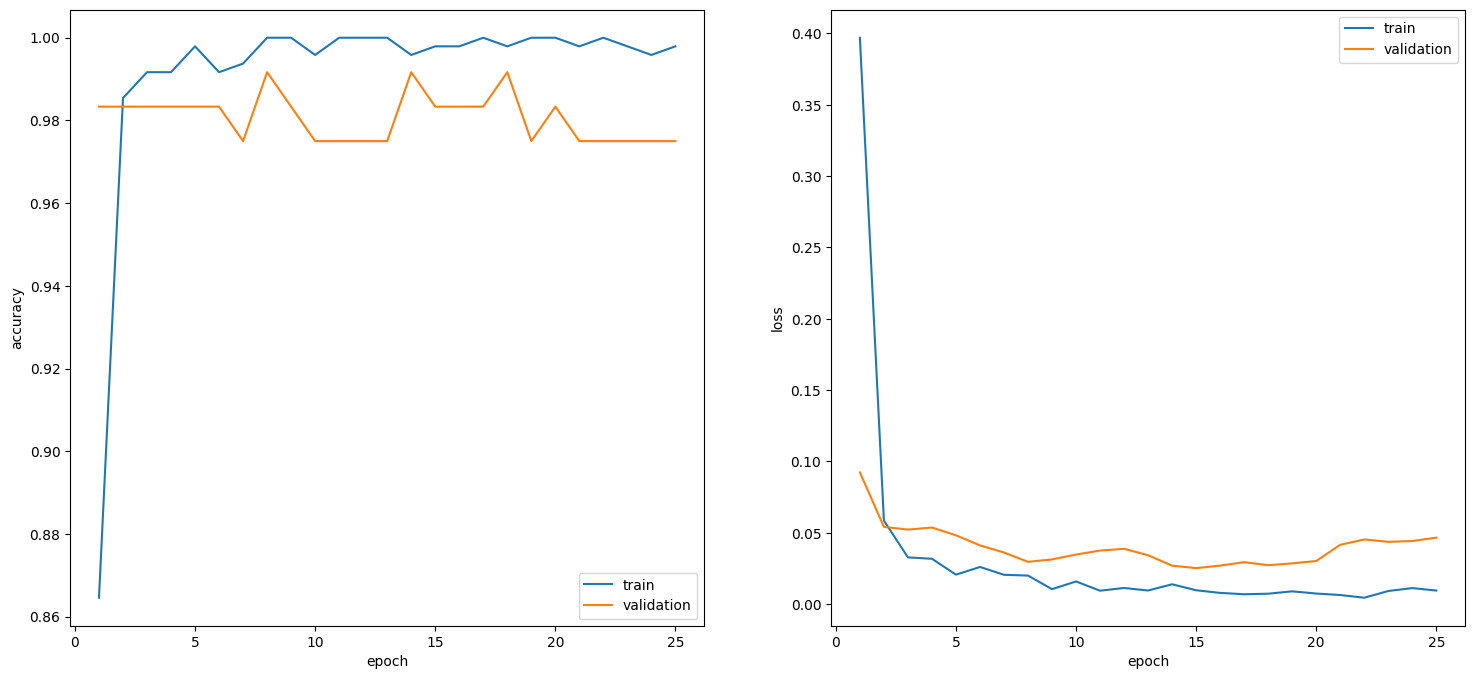

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
_ = sns.lineplot(metrics, x="epoch", y="train_accuracy", c="tab:blue", legend="brief", label="train", ax=ax[0])
_ = sns.lineplot(metrics, x="epoch", y="val_accuracy", c="tab:orange", legend="brief", label="validation", ax=ax[0])
_ = ax[0].set_ylabel("accuracy")
_ = sns.lineplot(metrics, x="epoch", y="train_loss", c="tab:blue", legend="brief", label="train", ax=ax[1])
_ = sns.lineplot(metrics, x="epoch", y="val_loss", c="tab:orange", legend="brief", label="validation", ax=ax[1])
_ = ax[1].set_ylabel("loss")

In [65]:
y_test = []
y_pred = []
for images, labels in test_dataloader:
    outputs = model(images)
    y_pred.extend(torch.max(outputs, dim=1)[1].tolist())
    y_test.extend(labels.tolist())

results = pd.DataFrame(
    {
        "y_true": y_test,
        "y_pred": y_pred,
    }
)
print(f"Test Accuracy - {accuracy_score(results["y_true"], results["y_pred"]):.6f}")

Test Accuracy - 0.983333


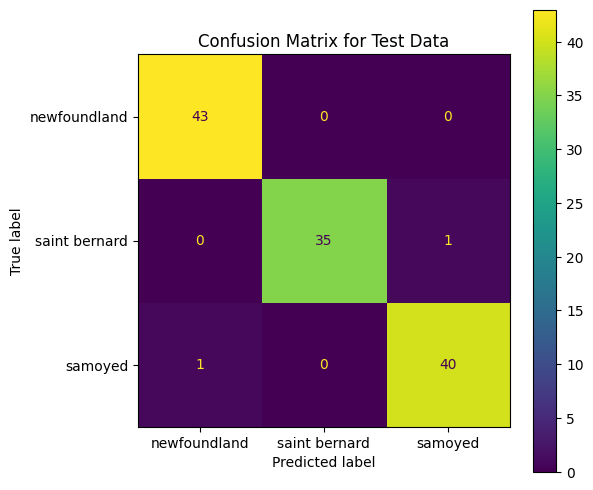

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(results["y_true"], results["y_pred"])
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
_ = disp.plot(ax=ax)
_ = ax.set_title("Confusion Matrix for Test Data")

We can see from the above confusion matrix that the Custom GoogLeNet model with linear layer performed very well on this classification task. 
- It correctly classified all Newfoundland dogs.
- It misclassified 1 Saint Bernard dog as Samoyed.
- It misclassified 1 Samoyed dog as Newfoundland.

Overall it achieved 98.33% accuracy on the test dataset.

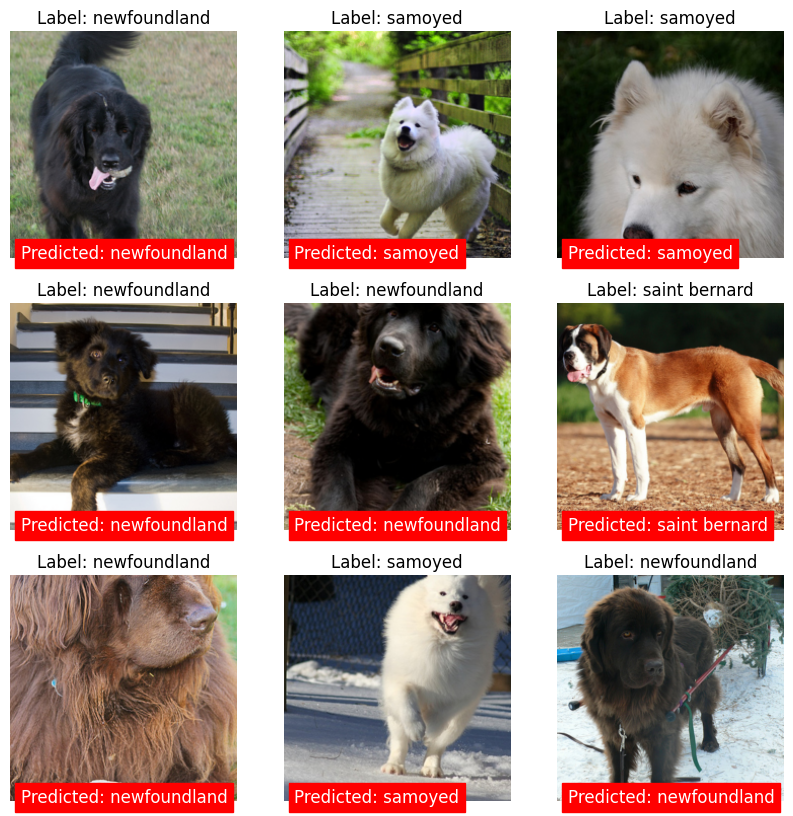

In [67]:
plt.figure(figsize=(10, 10))
for i in range(9):
    image = test_dataset[i][0].permute(1, 2, 0).numpy()
    image = image * [0.229, 0.224, 0.225]
    image = image + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {test_dataset.dataset.classes[test_dataset[i][1]]}")
    plt.text(
        10,
        224,
        f"Predicted: {CLASSES[y_pred[i]]}",
        fontsize=12,
        color="white",
        backgroundcolor="red",
    )
    plt.axis("off")

plt.show()

#### Conclusion

For the same test dataset, the custom GoogLeNet model achieved a 98.33% accuracy compared to 89.16% accuracy achieved by the Custom CNN built previously. This is possible because,
- Our dataset is pretty small, with only 120 images in the test dataset, each class containing 40 images.
- The Custom CNN implemented above was only limited to the 480 images chosen for training, and hence couldn't perform as well as  GoogLeNet model with linear layer.
- GoogLeNet, which was trained on ImageNet dataset, already understands the "concept" of a dog, since it is one of the classes in ImageNet. Hence, the GoogLeNet model with linear layer was quickly able to learn the differentiating features between the 3 species of dogs compared to the Custom CNN model implemented previously.